In [1]:
from utils import *
from Kpca import kPCA
from pca import PCA
from utils import param_heatmap, param_scatter, decision_boundary_plot, ROC_curve, check_d

import pandas as pd
import numpy as np
from numpy import random
from sklearn import metrics
import matplotlib.pyplot as plt
from pyod.models.ocsvm import OCSVM
from scipy.linalg import eigh
from sklearn.datasets import fetch_openml
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import resize
from keras.datasets import mnist
methods = ['kPCA','PCA','ParzenWindow','OCSVM']


C:\Users\vahed\AppData\Local\Temp\ipykernel_5688\129353479.py:14: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
def Digit0_dataset():
  background_digit = 0
  anomaly_digits = [1,2,3,4,5,6,7,8,9]
  new_size = 8
  n_bg_train = 2000
  n_bg_test = 980
  n_an_test = 109

  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  data = np.vstack((x_train,x_test))
  labels = np.concatenate((y_train,y_test))

  data = data.astype('float32') / 255
  bg_idx = np.where(labels == background_digit)


  x_train = data[bg_idx][:n_bg_train]
  x_bg_test = data[bg_idx][n_bg_train:n_bg_train+n_bg_test]

  an_idx = []
  for d in anomaly_digits:
      idx = np.where(labels == d)
      an_idx.append(idx)

  an_test = []
  for d in range(len(anomaly_digits)):
      idx = an_idx[d][0][:n_an_test]
      an_test.append(data[idx])
  x_an_test = np.vstack(an_test)

  y_test = np.zeros((x_bg_test.shape[0]+x_an_test.shape[0]))
  y_test[x_bg_test.shape[0]:]=1
  x_test = np.vstack((x_bg_test,x_an_test))

  #blur and resize and flatten
  x_train = gaussian_filter(x_train, sigma=1)#sigma not specified in paper
  x_test = gaussian_filter(x_test, sigma=1)#sigma not specified in paper
  x_train = resize(x_train, (x_train.shape[0],new_size,new_size))
  x_test = resize(x_test, (x_test.shape[0],new_size,new_size))

  #flatten
  x_train = np.reshape(x_train, [-1, new_size*new_size])
  x_test = np.reshape(x_test, [-1, new_size*new_size])

  test_size = x_test.shape[0]
  idx = np.random.randint(0,test_size, int(test_size/2))
  x_val = x_test[idx]
  y_val = y_test[idx]
  x_test = x_test[~idx]
  y_test = y_test[~idx] 
  return  x_train, x_val, y_val, x_test, y_test

In [3]:
# Data Prepration
num_search = 50 # Number of Parameters to search in the given interval
models = []
scores = []
test_aucs = []

x_train, x_val, y_val, x_test, y_test = Digit0_dataset()



## Fig10

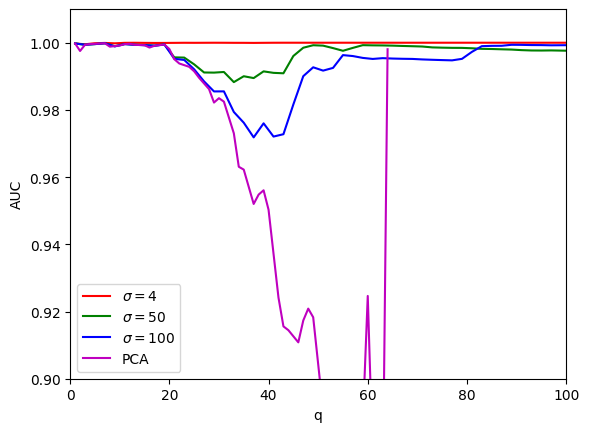

In [4]:
from sklearn import decomposition
fig, axs = plt.subplots(1,1)
num_params = num_search
sigmas = np.logspace(-2,2,num_params)
sigmas = np.array([4, 50, 100])
maxq = 100
qs = np.linspace(1,maxq,num_params,dtype = 'int')

gridsearch = np.zeros((len(sigmas)*len(qs),3)) #sigma, q, auc for each run
mesh = np.zeros((len(qs), len(sigmas)))

#perform gridsearch
run = 0
i= 0
for sigma in sigmas:
    j = 0
    for q in qs:
        model = kPCA(q = q, sigma = sigma)
        model.fit(x_train)
        val_scores = model.decision_function(x_val)
        auc = metrics.roc_auc_score(y_val,val_scores)
        gridsearch[run,:]= np.asarray([sigma,q,auc])
        mesh[j,i]=auc
        run += 1
        j += 1
    i += 1

# param_scatter(methods[1],fig,axs,gridsearch[:,0],gridsearch[:,1],'q',log=False)
idx = np.where(gridsearch[:,0] == sigmas[0])
axs.plot(gridsearch[idx,1].ravel(),gridsearch[idx,2].ravel(), color = 'r', label=r'$\sigma = {}$'.format(sigmas[0]))

idx = np.where(gridsearch[:,0] == sigmas[1])
axs.plot(gridsearch[idx,1].ravel(),gridsearch[idx,2].ravel(), color = 'g', label=r'$\sigma = {}$'.format(sigmas[1]))

idx = np.where(gridsearch[:,0] == sigmas[2])
axs.plot(gridsearch[idx,1].ravel(),gridsearch[idx,2].ravel(), color = 'b', label=r'$\sigma = {}$'.format(sigmas[2]))


maxq = 62
qs = np.linspace(1,maxq,num_params,dtype = 'int')
gridsearch = np.zeros((len(qs),2))

#perform gridsearch
run = 0


for q in qs:
    # model = PCA(q)
    # model.fit(x_train)
    # val_scores = model.decision_function(x_val)

    model = decomposition.PCA(n_components=q)
    model.fit(x_train)
    x_val_transformed = model.transform(x_val)
    val_scores = np.sum((model.inverse_transform(x_val_transformed) - x_val) ** 2, axis=1)

    auc = metrics.roc_auc_score(y_val,val_scores)
    gridsearch[run,:]= np.asarray([q,auc])
    run += 1

axs.plot(gridsearch[:,0].ravel(),gridsearch[:,1].ravel(), color = 'm',label = methods[1],ms=2)

axs.set_ylim([0.9, 1.01])
axs.set_xlim([0, 100])
axs.set_xlabel('q')
axs.set_ylabel('AUC')
axs.legend()
# fig, axs = plt.subplots(1,1)
# param_heatmap(methods[0],fig,axs,sigmas,qs,mesh,"sigma",'q',best_sigma,best_q,log=True)

# decision_boundary_plot(x_train, x_test, y_test, x_val, y_val, [model],methods[0])


## Fig 9

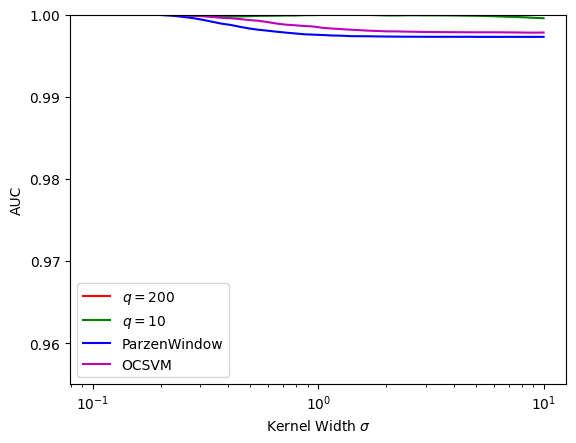

In [5]:
from sklearn import decomposition
models = []
scores = []
test_aucs = []
fig, axs = plt.subplots(1,1)
num_params = num_search
sigmas = np.logspace(-1,1,num_params)
# sigmas = np.array([1, 5, 15])
maxq = 80
# qs = np.linspace(1,maxq,num_params,dtype = 'int')
qs = np.array([200, 10])

gridsearch = np.zeros((len(sigmas)*len(qs),3)) #sigma, q, auc for each run
mesh = np.zeros((len(qs), len(sigmas)))

#perform gridsearch
run = 0
i= 0
for sigma in sigmas:
    j = 0
    for q in qs:
        model = kPCA(q = q, sigma = sigma)
        model.fit(x_train)
        val_scores = model.decision_function(x_val)
        auc = metrics.roc_auc_score(y_val,val_scores)
        gridsearch[run,:]= np.asarray([sigma,q,auc])
        mesh[j,i]=auc
        run += 1
        j += 1
    i += 1

# param_scatter(methods[1],fig,axs,gridsearch[:,0],gridsearch[:,1],'q',log=False)
idx = np.where(gridsearch[:,1] == qs[0])
axs.plot(gridsearch[idx,0].ravel(),gridsearch[idx,2].ravel(), color = 'r', label=r'$q = {}$'.format(qs[0]))

idx = np.where(gridsearch[:,1] == qs[1])
axs.plot(gridsearch[idx,0].ravel(),gridsearch[idx,2].ravel(), color = 'g', label=r'$q = {}$'.format(qs[1]))


#perform gridsearch
run = 0


gridsearch = np.zeros((len(sigmas),2))

#perform gridsearch
run = 0
for sigma in sigmas:
    model = kPCA(q = 0,sigma = sigma)
    model.fit(x_train)
    val_scores = model.decision_function(x_val)
    auc = metrics.roc_auc_score(y_val,val_scores)
    gridsearch[run,:]= np.asarray([sigma,auc])
    run += 1

axs.plot(gridsearch[:,0].ravel(),gridsearch[:,1].ravel(), color = 'b',label = methods[2],ms=2)
# axs.plot(gridsearch[:,0].ravel(),gridsearch[:,1].ravel(), color = 'm',label = methods[1],ms=2)


gridsearch = np.zeros((len(sigmas),2))
#perform gridsearch
run = 0
i= 0
for sigma in sigmas:
    gamma = 0.5/(sigma*sigma)
    model = OCSVM(gamma = gamma)
    model.fit(x_train)
    val_scores = model.decision_function(x_val)
    auc = metrics.roc_auc_score(y_val,val_scores)
    gridsearch[run,:]= np.asarray([sigma,auc])
    run += 1
axs.plot(gridsearch[:,0].ravel(),gridsearch[:,1].ravel(), color = 'm',label = methods[3],ms=2)



axs.set_xscale('log')
# plt.yticks(np.arange(0.965,1, 0.001))  # Adjust the step to a suitable interval
# plt.yticks(np.arange(0.9958, 0.9972, 0.0002))
# axs.yaxis.set_tick_params(size=5, width=1)  # Modify 'size' and 'width' as needed

axs.set_ylim([0.955, 1])
# axs.set_xlim([0.1, 10])
axs.set_xlabel(r'Kernel Width $\sigma$')
axs.set_ylabel('AUC')
axs.legend()
# fig, axs = plt.subplots(1,1)
# param_heatmap(methods[0],fig,axs,sigmas,qs,mesh,"sigma",'q',best_sigma,best_q,log=True)

# decision_boundary_plot(x_train, x_test, y_test, x_val, y_val, [model],methods[0])

## Fig 8

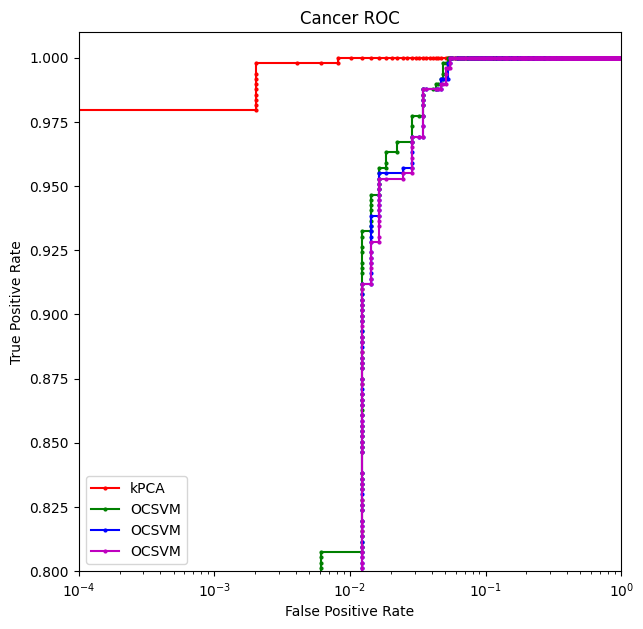

In [6]:
num_search = 150 # Number of Parameters to search in the given interval
models = []
scores = []
test_aucs = []

best_sigma = 4
best_q = 100
model = kPCA(q = int(best_q), sigma = best_sigma)
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
test_auc = metrics.roc_auc_score(y_test,test_scores)
test_aucs.append(test_auc)
models.append(model)


sigma=1.2
gamma = 0.5/(sigma*sigma)
model = OCSVM(gamma = gamma)
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
test_auc = metrics.roc_auc_score(y_test,test_scores)
test_aucs.append(test_auc)
models.append(model)

sigma=2
gamma = 0.5/(sigma*sigma)
model = OCSVM(gamma = gamma)
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
test_auc = metrics.roc_auc_score(y_test,test_scores)
test_aucs.append(test_auc)
models.append(model)

sigma=10
gamma = 0.5/(sigma*sigma)
model = OCSVM(gamma = gamma)
model.fit(x_train) #still using model data
test_scores = model.decision_function(x_test)
scores.append(test_scores)
test_auc = metrics.roc_auc_score(y_test,test_scores)
test_aucs.append(test_auc)
models.append(model)

# ROC Curve
key= 'Cancer'
methods = ['kPCA','OCSVM','OCSVM','OCSVM']
fig, ax = plt.subplots(figsize=(7,7))
colors = ['r','g','b','m']
for i in range(len(methods)):
    fpr,tpr,_ = metrics.roc_curve(y_test,scores[i],drop_intermediate = False)
    tpr[1] = 0
    if test_aucs[i] == 0.5:
        fpr = np.linspace(0,1,100)
        tpr = fpr
    ax.plot(fpr,tpr, color = colors[i], marker='o',label = methods[i],ms=2)
x=np.linspace(0,1,100)
y = x
# ax.plot(x,y,ls = "--",label='random')
ax.set_ylim([0.8, 1.01])
ax.set_xlim([1e-4,1])
ax.legend()
ax.set_title(key+' ROC')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xscale('log')